In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd gdrive/My Drive/FYP

# Segment out makeup


In [ ]:
os.path.dirname("face_makeup_PyTorch/test.py")

'face_makeup_PyTorch'

In [ ]:
os.chdir("face_makeup_PyTorch")

In [ ]:
import torch
import os
from model import BiSeNet
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2


def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    return vis_parsing_anno
    # return vis_im


def evaluate(image_path='./imgs/116.jpg', cp='cp/79999_iter.pth'):

    # if not os.path.exists(respth):
    #     os.makedirs(respth)

    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path).convert('RGB')
        #image = img.resize((512, 512), Image.BILINEAR)
        image = img
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        # print(parsing)
        # print(np.unique(parsing))

        # vis_parsing_maps(image, parsing, stride=1, save_im=False, save_path=osp.join(respth, dspth))
        return parsing

In [ ]:
import cv2
import os
import numpy as np
from skimage.filters import gaussian
#from test import evaluate
import argparse
from google.colab.patches import cv2_imshow

def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, multichannel=True)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)


def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    changed[parsing != part] = image[parsing != part]
    return changed


In [ ]:
os.listdir("..")

['t1.jpg',
 'facetools',
 'face-parsing.PyTorch',
 'colour_transfer',
 '=2.0.1',
 'fcn_pytorch.ipynb',
 'segmented face',
 'original face',
 'face_makeup_PyTorch',
 'result',
 'FYP Interim Report.gdoc',
 'girl15.csv',
 'out.png',
 'girl21.csv',
 'girl_3.csv',
 'girl.csv',
 'Full.ipynb',
 'source',
 'target',
 'result_one_dimensional',
 'result_N_dimensional',
 'FYP REPORT',
 'report',
 'Final Colour Transfer.ipynb',
 'output2.png',
 'result_lips',
 'original face OpenFace',
 'result_eyebrows',
 'result_eyes',
 'results_skin',
 'result_face',
 'Lips Color Transfer Unsegmented.ipynb',
 'chapter4.drawio',
 'Untitled Diagram.drawio',
 'Hair Color Transfer Unsegmented.ipynb']

## HAIR TARGET

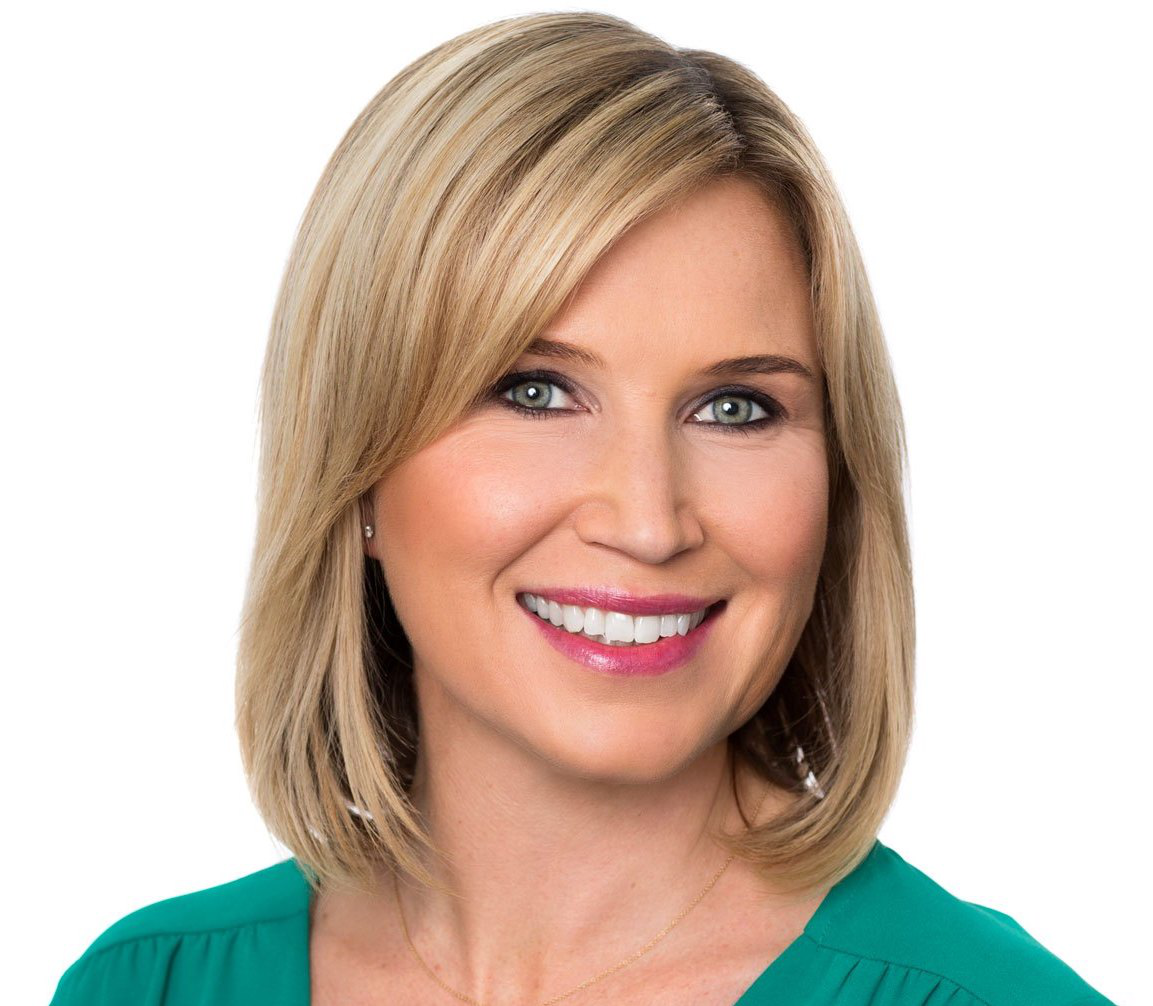

In [ ]:
from PIL import Image
# 1  face
# 11 teeth
# 12 upper lip
# 13 lower lip
# 17 hair


table = {
    'hair': 17,
    'upper_lip': 12,
    'lower_lip': 13
}


cp = 'cp/79999_iter.pth'

# image = cv2.imread(image_path)

# #image=data
image_path="../original face/girl19.jpg"
image = Image.open(image_path)
# convert image to numpy array
og_image = np.array(image)
image

--- 0.6026637554168701 seconds ---
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


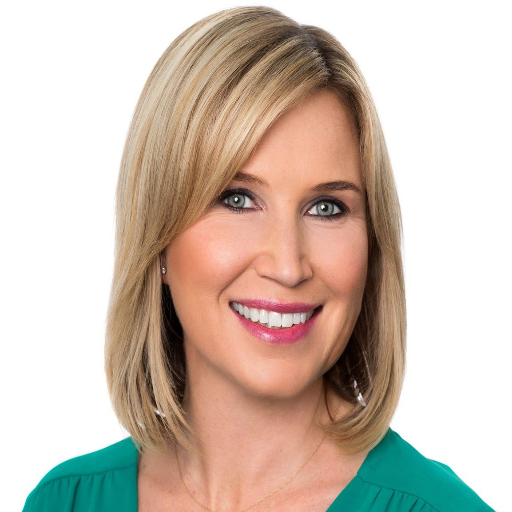

In [ ]:

import time
ori = og_image.copy()


start_time = time.time()
parsing = evaluate(image_path, cp)
print("--- %s seconds ---" % (time.time() - start_time))


print(parsing)
colors = [[230, 50, 20], [20, 70, 180], [20, 70, 180]]

cv2_imshow(cv2.resize(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB), (512, 512)))

In [ ]:
hair_target = og_image

In [ ]:
hair_target = np.zeros((og_image.shape[0],og_image.shape[1],4))

In [ ]:
og_image.shape

(1006, 1153, 3)

In [ ]:
hair_target.shape

(1006, 1153, 4)

In [ ]:
parsing.shape

(1006, 1153)

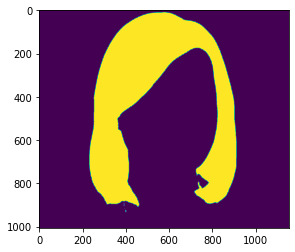

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(parsing==17)

In [ ]:
for x in range(len(parsing)):
  for y in range(len(parsing[0])):
    if (parsing[x][y]==17):
      hair_target[x][y][0]=og_image[x][y][0]
      hair_target[x][y][1]=og_image[x][y][1]
      hair_target[x][y][2]=og_image[x][y][2]
      hair_target[x][y][3]=255
    else:
      hair_target[x][y][3]=0

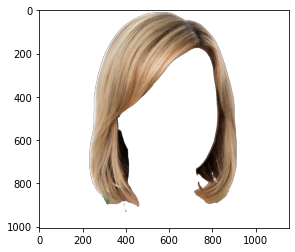

In [ ]:
plt.imshow(hair_target/255)

## HAIR SOURCE

In [ ]:
from PIL import Image
# 1  face
# 11 teeth
# 12 upper lip
# 13 lower lip
# 17 hair


table = {
    'hair': 17,
    'upper_lip': 12,
    'lower_lip': 13
}


cp = 'cp/79999_iter.pth'

# image = cv2.imread(image_path)

# #image=data
# image_path="../segmented face/segmentedgirl5.png"
image_path="../original face/image/6.jpg"

image = Image.open(image_path)
# convert image to numpy array
og_image = np.array(image)
image

Output hidden; open in https://colab.research.google.com to view.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


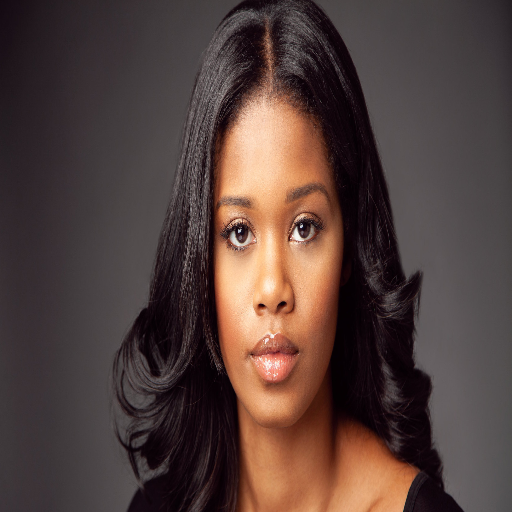

In [ ]:
ori = og_image.copy()
parsing = evaluate(image_path, cp)

print(parsing)
colors = [[230, 50, 20], [20, 70, 180], [20, 70, 180]]
cv2_imshow(cv2.resize(cv2.cvtColor(og_image, cv2.COLOR_BGR2RGB), (512, 512)))

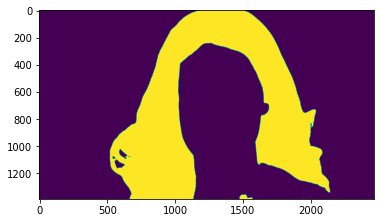

In [ ]:
plt.imshow(parsing==17)

In [ ]:
hair_source = og_image

In [ ]:
hair_source = np.zeros((og_image.shape[0],og_image.shape[1],4))

In [ ]:
for x in range((hair_source.shape[0])):
  for y in range((hair_source.shape[1])):
    if (parsing[x][y]==17):
      hair_source[x][y][0]=og_image[x][y][0]
      hair_source[x][y][1]=og_image[x][y][1]
      hair_source[x][y][2]=og_image[x][y][2]
      hair_source[x][y][3]=255
    else:
      hair_source[x][y][3]=0

In [ ]:
hair_source.shape

(1390, 2471, 4)

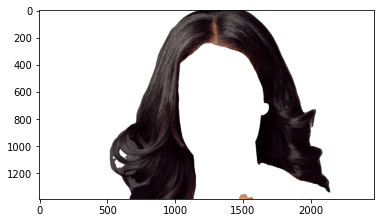

In [ ]:
plt.imshow(hair_source/255)

# Color HAIR

In [ ]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging

from collections import OrderedDict
from itertools import combinations
from IPython.core.debugger import set_trace

logging.basicConfig(level=logging.DEBUG)

In [ ]:
def colour_transfer_IDT(I0=None,I1=None,nb_iterations=None,*args,**kwargs):
    #varargin = colour_transfer_IDT.varargin
    #nargin = colour_transfer_IDT.nargin

    if (I0.ndim != 3):
        error('pictures must have 3 dimensions')
    
    nb_channels=np.shape(I0)[2]
# colour_transfer_IDT.m:23
    ## reshape images as 3xN matrices

    D0 = np.zeros((3, np.dot(len(I0),len(I0[0]))))
    D1 = np.zeros((3, np.dot(len(I1),len(I1[0]))))
    for i in range(0,3):
        print("here")

        D0[i,:]=np.reshape(I0[:,:,i],np.dot(len(I0),len(I0[0])), order="F")
# colour_transfer_IDT.m:27
        D1[i,:]=np.reshape(I1[:,:,i],np.dot(len(I1),len(I1[0])), order="F")
# colour_transfer_IDT.m:28
    
    ## building a sequence of (almost) random projections
#
    R = np.zeros((nb_iterations,6,3))
    R[0]=np.array([[1,0,0],[0,1,0],[0,0,1],[2 / 3,2 / 3,- 1 / 3],[2 / 3,- 1 / 3,2 / 3],[- 1 / 3,2 / 3,2 / 3]])
    # colour_transfer_IDT.m:34
    for i in range(1,nb_iterations):
        R[i]=np.dot(R[0],sp.linalg.orth(np.random.randn(3,3)))

    DR=pdf_transfer(D0,D1,R)
# colour_transfer_IDT.m:41
    ## reshape the resulting 3xN matrix as an image
    IR=I0.copy()
# colour_transfer_IDT.m:44
    for i in range(0,3):
        IR[:,:,i]=np.reshape(DR[i,:],(len(IR),len(IR[0])), order="F")

    return IR

In [ ]:

def pdf_transfer(D0=None,D1=None,Rotations=None,*args,**kwargs):
    prompt=''
    eps = 1e-6
# pdf_transfer.m:34
    for it in range(0,nb_iterations):
# pdf_transfer.m:38
        #fprintf(prompt)
        R=Rotations[it]
# pdf_transfer.m:41
        print("it.    " ,it)
        nb_projs=len(R)
# pdf_transfer.m:42
        
        D0R=np.dot(R,D0)
# pdf_transfer.m:46
        D1R=np.dot(R,D1)
# pdf_transfer.m:47
        D0R_=np.zeros(D0R.shape)

        
# pdf_transfer.m:48
        for i in range(0,nb_projs):
            # if(i==3):
            #   break;
            # get the data range
            print("i         ",i)

            datamin=min(np.concatenate((D0R[i,:],D1R[i,:]))) - eps
# pdf_transfer.m:53
            datamax=max(np.concatenate((D0R[i,:],D1R[i,:]))) + eps
# pdf_transfer.m:54
            # u=np.arange(1,(301)) / (301)*(datamax - datamin) + datamin
            # u_edge=np.arange(1,(301)) / (301)*(datamax - datamin)
            print("datamax ", datamax)
            print("datamin ", datamin)
            u=(np.arange(0,(300))/(300-1))*(datamax - datamin) + datamin
            u_edge=(np.arange(-0.5,300.5,1)/(300.5-1))*(datamax - datamin)+ datamin
            print("max u_edge ", max(u_edge))
            print("min u_edge ", min(u_edge))
            print("max u ", max(u))
            print("min u ", min(u))
# pdf_transfer.m:55
            p0R,bins1,patches=plt.hist(D0R[i,:],bins = u_edge)
            print("is my bin edge same as u_edge?",u_edge == bins1)
            print("_before  pdf_transfer1D_")
# pdf_transfer.m:58
            #p1R=plt.hist(D1R[i,:],u)
            p1R,bins2,patches2=plt.hist(D1R[i,:],bins = u_edge)
# pdf_transfer.m:59
            f=pdf_transfer1D(p0R,p1R,bins1.size,bins2.size)
# pdf_transfer.m:62
            #u=np.arange(0,(300)) / (300)*(datamax - datamin) + datamin
            
            newfun = sp.interpolate.interp1d(x = u, y = f.T,kind='linear')
            
            # print("I DID IT")
            x= D0R[i,:]
            print("max x ", max(x))
            print("min x ", min(x))
            print(" after interp1d")
            newy  = newfun(x)
            D0R_[i,:]=( newy - 1) /(300-1)*(datamax-datamin) + datamin;
            # D0R_[i,:]=np.interp(D0R[i,:],edges[1:],f.T)/(300-1)*(datamax-datamin) + datamin;
            # print("))))")
            # D0R_[i,:]=np.dot((interp1(u,f.T,D0R[i,:]) - 1) / (300 - 1),(datamax - datamin)) + datamin
# pdf_transfer.m:65
        # print("DO ",D0.shape)
        # print("D0R_ ", D0R_.shape)
        # print("D0R ", D0R_.shape)
        # print("R ",R.shape)
        lin, residuals, rank, s = np.linalg.lstsq(R,(D0R_ - D0R))
        print("lin", lin.shape)
        D0=relaxation * lin + D0
# pdf_transfer.m:68
    
    
    DR=D0.copy()
# pdf_transfer.m:74
    return DR
    

    
    # 1D - PDF Transfer
    
def pdf_transfer1D(pX=None,pY=None,bins=None,bins2=None,*args,**kwargs):
    #varargin = pdf_transfer1D.varargin
    #nargin = pdf_transfer1D.nargin
    print("in pdf_transfer1D")
    nbins=bins
    #print(pX)
# pdf_transfer.m:82
    eps=[1e-06]
    x = pX+eps
    PX=x.cumsum()
# pdf_transfer.m:86
    PX=PX / PX[-1]
# pdf_transfer.m:87
    y = pY + eps
    PY=y.cumsum()
# pdf_transfer.m:89
    PY=PY / PY[-1]
    print("PX min ", min(PX))
    print("PX max ", max(PX))

    print("PY min ", min(PY))
    print("PY max ", max(PY))

    f=sp.interpolate.interp1d(x = PY, y=np.arange(0,nbins-1),kind='linear',fill_value="extrapolate")
    b=f(PX)
    print(b.size)
    #f=interp1(PY,np.arange(0,nbins - 1),PX,'linear')
# pdf_transfer.m:94
    b[PX <= PY[0]]=0
# pdf_transfer.m:95
    b[PX >= PY[-1]]=nbins - 1
# pdf_transfer.m:96
    if sum(np.isnan(b)) > 0:
        error('colour_transfer:pdf_transfer:NaN','pdf_transfer has generated NaN values')
    print("out pdf_transfer1D")
    
    return b
    


In [ ]:
# I1 = plt.imread('purplehair.jpeg')/255
# #I1 = plt.imread('hair.jpg')/255
I1 = hair_target/255
I0 = hair_source/255
# I1 = hair_source
# I0 = hair_target
relaxation=1
nb_iterations=10

here
here
here
it.     0
i          0
datamax  1.000001
datamin  -1e-06
max u_edge  1.000001
min u_edge  -0.0016704524207011684
max u  1.000001
min u  -1e-06
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


max x  0.7006535947712418
min x  -0.03529411764705882
 after interp1d
lin (3, 3434690)
it.     1
i          0
datamax  1.0109120811504904
datamin  -0.11274009064336307
max u_edge  1.0109120811504904
min u_edge  -0.11461597072983028
max u  1.0109120811504904
min u  -0.11274009064336307
is my bin edge same as u_edge? [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  

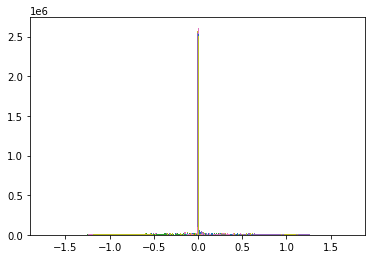

In [ ]:

import time

start_time = time.time()
IR_idt=colour_transfer_IDT(I0,I1,10)
print("--- %s seconds ---" % (time.time() - start_time))

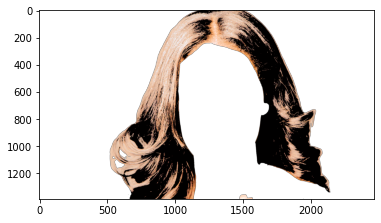

In [ ]:
plt.imshow(IR_idt)

In [ ]:
IR_idt.shape

(1390, 2471, 4)

In [ ]:
image_path="../original face/image/6.jpg"

In [ ]:
cp2= IR_idt

In [ ]:
type(cp2[0][0][0])

numpy.float64

In [ ]:
og = np.asarray(plt.imread(image_path),dtype=np.float64)

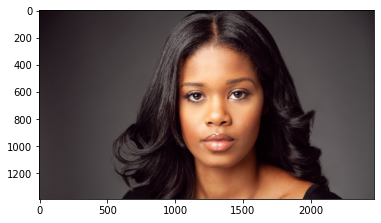

In [ ]:
og = og/255
plt.imshow(og)

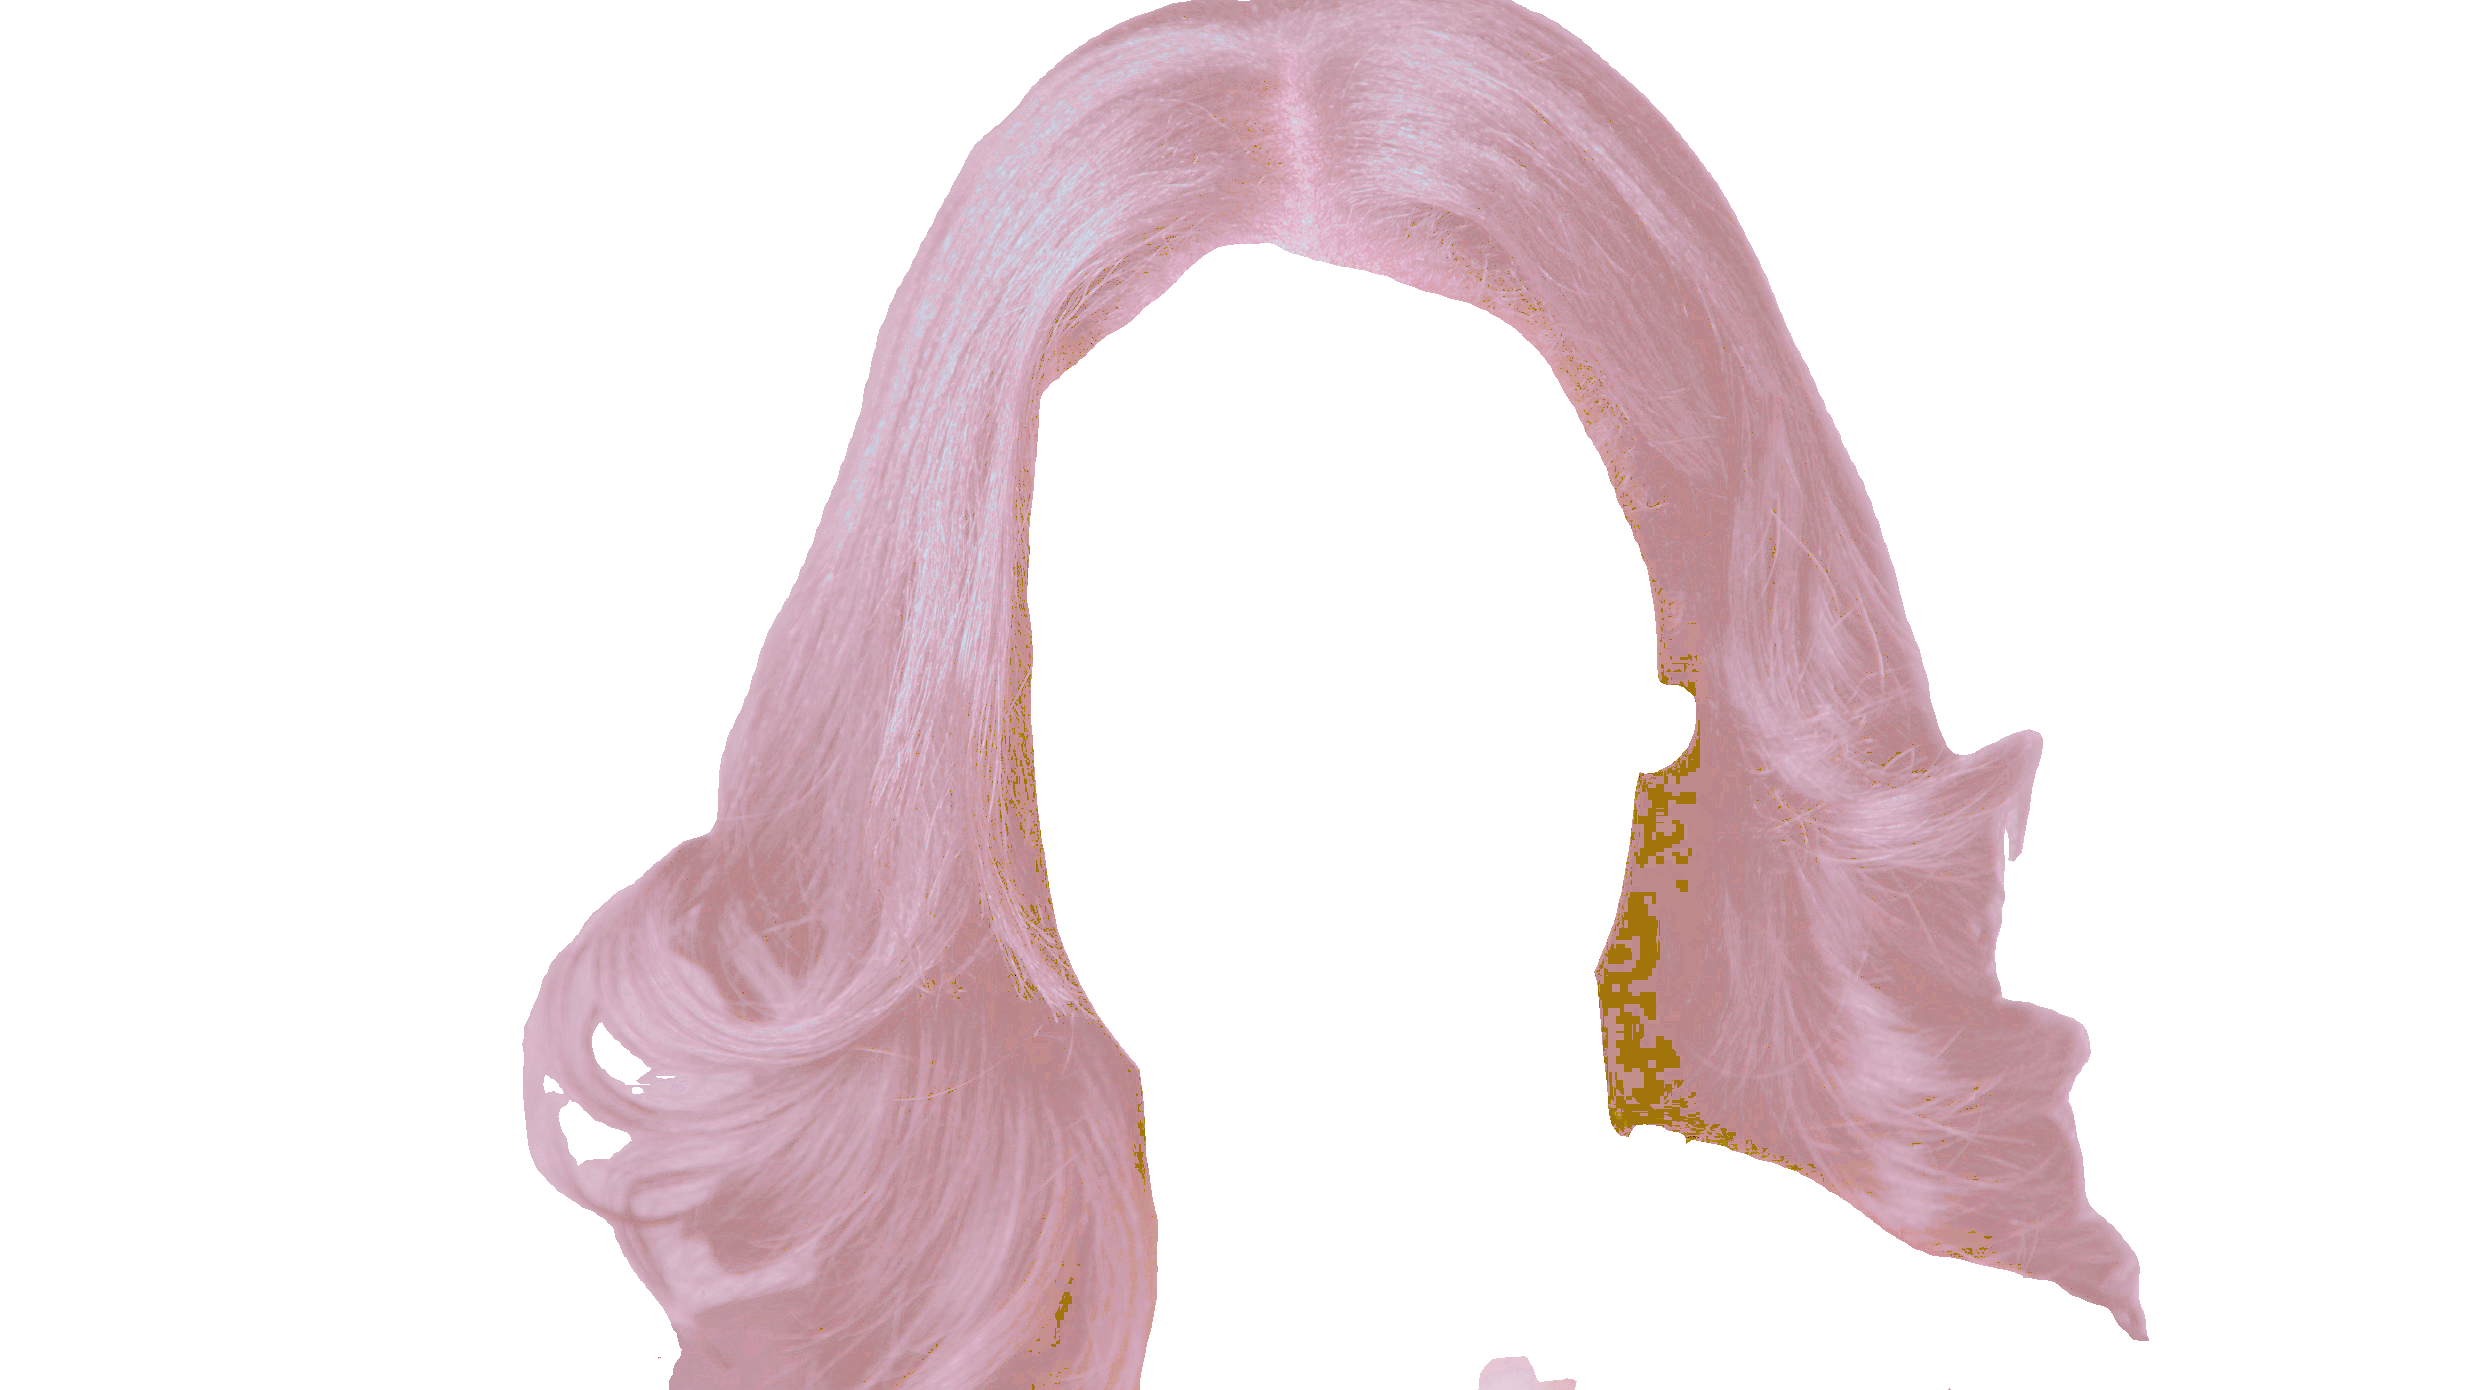

In [ ]:
from skimage import img_as_ubyte

img2 = img_as_ubyte(cp2/np.max(cp2))
Image.fromarray(img2)

In [ ]:
from PIL import Image
import numpy as np
# load the image
#image = cv2.imread(image_path)

og2 = og
cp2= IR_idt
for x in range(IR_idt.shape[0]):
  for y in range(IR_idt.shape[1]):
    if (cp2[x,y,3]==1.0):
      og2[x,y,0]=cp2[x,y,0]
      og2[x,y,1]=cp2[x,y,1]
      og2[x,y,2]=cp2[x,y,2]
      #og2[x,y,3]=1
      # new[x][y][3]=255

In [ ]:
np.max(og2)

1.0

In [ ]:
from skimage import img_as_ubyte

img = img_as_ubyte(og2/np.max(og2))

In [ ]:
#HAIR
img2 = Image.fromarray(img)

In [ ]:
img2.save("../result/girl19_girl_result2.jpg")

In [ ]:
img2.save("../result/A7_girl_result.jpg")

In [ ]:
img2.save("../result/girl26_girl_result.jpg")

In [ ]:
img2.save("../result/13_girl_result.jpg")

In [ ]:
img2.save("../result/9_girl_result.jpg")

In [ ]:
img2.save("../result/17_girl_result.jpg")

In [ ]:
img2.save("../result/12_girl_result2.jpg")

In [ ]:
img2.save("../result/16_6_result.jpg")

In [ ]:
img2.save("../result/26_6_result.jpg")

In [ ]:
img2.save("../result/girl_2_6_result.jpg")

In [ ]:
img2.save("../result/12_6_result4.jpg")

In [ ]:
img2.save("../result/17_6_result.jpg")

In [ ]:
img2.save("../result/1_6_result.jpg")

In [ ]:
img2.save("../result/8_6_result.jpg")